## Packages

In [1]:
import numpy as np
import os
import pandas as pd
import time
from pathlib import Path
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM
from avalanche.logging import (
    InteractiveLogger,
    TextLogger,
    CSVLogger,
)
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import multiprocessing as mp
import my_utils
import my_architectures
import my_dataloaders
# import my_gwpy_and_fractals
import my_transformations
IMG_SIZE = (224,224)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

4


In [3]:
# Setting the correct directories
train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
#train_dir = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_1'
train_dir_2 = 'D:\\Users\Brian\\TrainingSet_CL_2\\TrainingSet_CL_2'
#train_dir_2 = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_2'
val_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
#val_dir = 'C:\\Users\\Brian.Baert\\ValidationSet_CL'
test_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
#test_dir = 'C:\\Users\\Brian.Baert\\TestSet_CL'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

## MultiView Fusion Naive model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
model.to(device)
# log to text file
text_logger = TextLogger(open("multiview_fusion_naive_log.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

In [5]:
print(classes)

['Blip', 'Blip_Low_Frequency', 'Extremely_Loud', 'Fast_Scattering', 'Koi_Fish', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'Scattered_Light', 'Tomte', 'Whistle']


In [6]:
train_set = my_dataloaders.MultiViewGravitySpyDataset(root=train_dir, cls=classes, transform=my_transformations.transformAV_Fuse_448_Crop)
val_set = my_dataloaders.MultiViewGravitySpyDataset(root=val_dir, cls=classes, transform=my_transformations.transformAV_448_Fuse)
test_set = my_dataloaders.MultiViewGravitySpyDataset(root=test_dir, cls=classes, transform=my_transformations.transformAV_448_Fuse)

train_set_av = AvalancheDataset(train_set)
train_loader_av = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

val_set_av = AvalancheDataset(val_set)
val_loader_av = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

test_set_av = AvalancheDataset(test_set)
test_loader_av = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

train_set_av.targets = [label for i, label in enumerate(train_set.labels) if i % 4 == 0]
test_set_av.targets = [label for i, label in enumerate(test_set.labels) if i % 4 == 0]
val_set_av.targets = [label for i, label in enumerate(val_set.labels) if i % 4 == 0]

train_set_av.uniques = list(set(train_set.labels))
test_set_av.uniques = list(set(test_set.labels))
val_set_av.uniques = list(set(val_set.labels))

In [27]:
# Get the first batch from the dataloader
batch = next(iter(train_set))

# Extract the first image and its label (if available)
image, label = batch

In [28]:
image.shape

torch.Size([3, 448, 448])

In [29]:
label

0

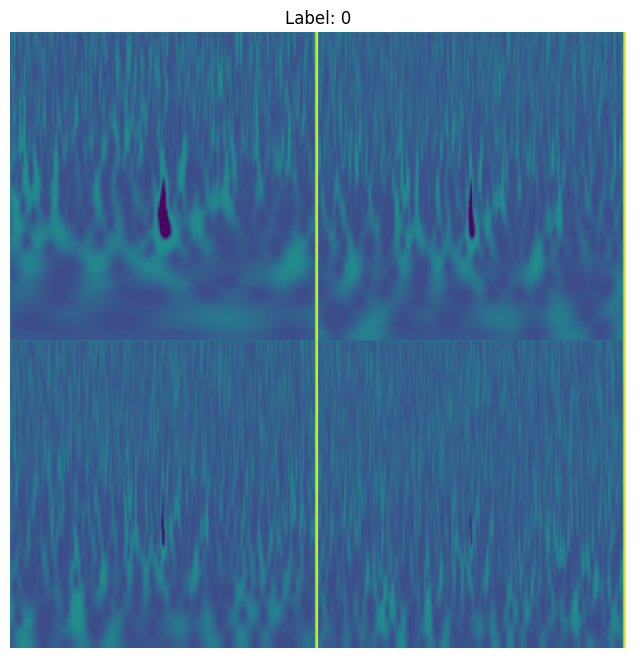

In [30]:
# Convert image tensor to numpy array
image_np = image[2].numpy()
# Create a subplot and display the image
plt.figure(figsize=(8,8))
plt.imshow(image_np)
#plt.imshow(image_np.transpose(1, 2, 0))  # Transpose to (H, W, C) format
plt.axis('off')  # Hide axes
plt.title(f"Label: {label}") if label is not None else plt.title("First Image")
plt.show()

In [11]:
bm = nc_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=5,
    shuffle=True,
    seed=1234,
    task_labels=False,
    class_ids_from_zero_in_each_exp=False,
)

In [12]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=False, stream=True),
    ram_usage_metrics(experience=True, stream=True, epoch=False),
    bwt_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

In [ ]:
# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()
#criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [ ]:
# NAIVE STRATEGY
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=5, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), EarlyStoppingPlugin(patience=2, val_stream_name='train')]
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'naive_fusion')

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_MultiView_Naive_CL.pth')

In [ ]:
# SOME TEST PREDICTIONS
my_utils.n_test_predictions(model, test_loader_av, classes, 20)

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_MultiView_Naive.png')

In [ ]:
my_utils.plot_tSNE_data_embedding(model, train_loader_av, classes, 'Results/tSNE_MultiView_Naive.png')

## Multiview Fusion LwF model

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
model.to(device)
# log to text file
text_logger = TextLogger(open("multiview_fusion_LwF_log.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

In [34]:
# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()
#criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [35]:
# STRATEGY 
# ALPHA AND TEMPERATURE are taken from the paper by Oren & Wolf - "In defense of the Learning Without Forgetting for Task Incremental Learning"
cl_strategy = LwF(
    model=model, optimizer=optimizer, criterion=criterion, alpha=0.25, temperature=2.0, 
    train_mb_size=64, train_epochs=5, eval_mb_size=32, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set))] #Early stopping is not used here because LwF does not inherently support Early Stopping
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.LwF object at 0x0000022C610DADD0>
Start of experience:  0
Current Classes:  [4, 5]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:23<00:00,  3.30s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5639
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7025
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.01s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4683
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9975
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.06s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1298
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9975
100%|███████████████████████████████████████████████████

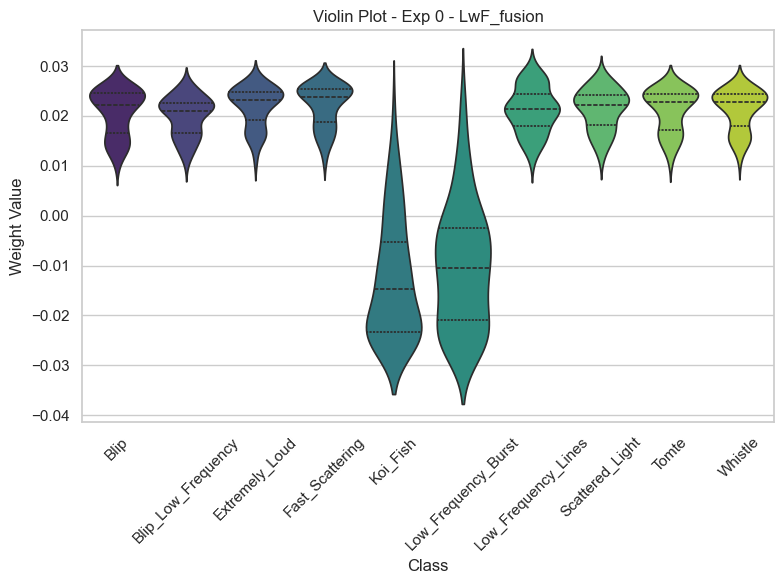

Start of experience:  1
Current Classes:  [8, 2]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:42<00:00,  6.06s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.1557
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5000
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:41<00:00,  5.90s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9261
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7200
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:41<00:00,  5.88s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3834
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9537
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:41<00:00,  5.95s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

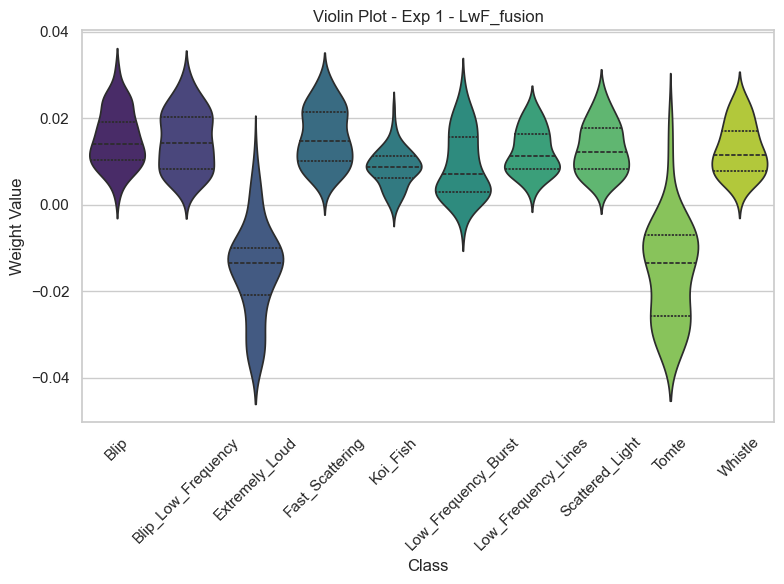

Start of experience:  2
Current Classes:  [9, 6]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:45<00:00,  6.51s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.0286
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4540
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:45<00:00,  6.46s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2270
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4976
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:45<00:00,  6.48s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8908
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7818
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.43s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

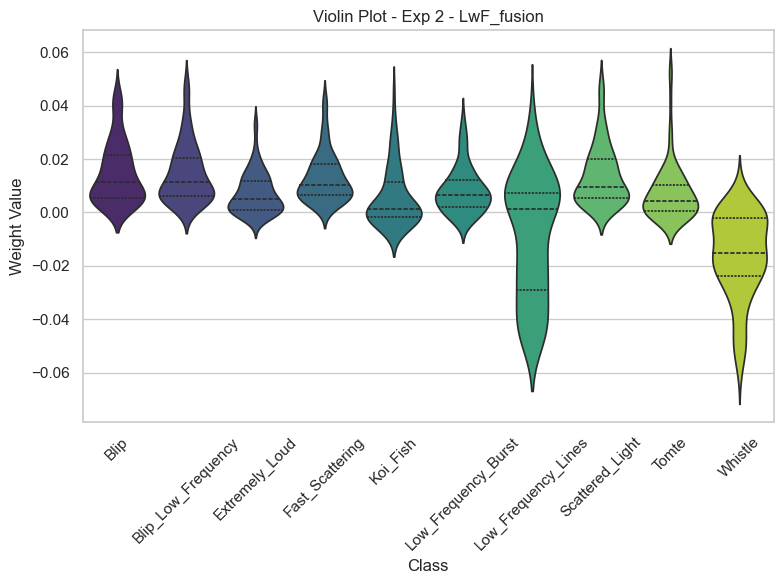

Start of experience:  3
Current Classes:  [1, 7]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:45<00:00,  6.43s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.4448
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3774
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.40s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5832
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4717
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.34s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1083
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6238
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.31s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

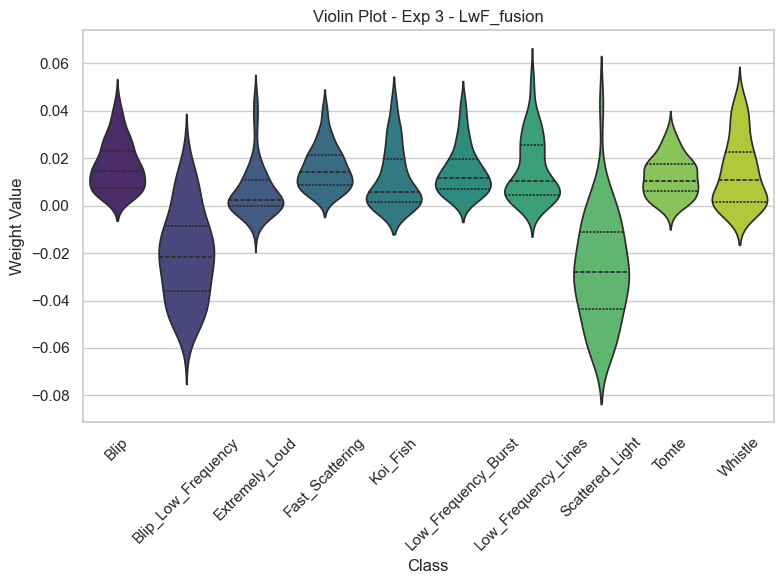

Start of experience:  4
Current Classes:  [0, 3]
-- >> Start of training phase << --
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.35s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.5594
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4281
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.33s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6531
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4658
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.42s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3603
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4988
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.40s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Ta

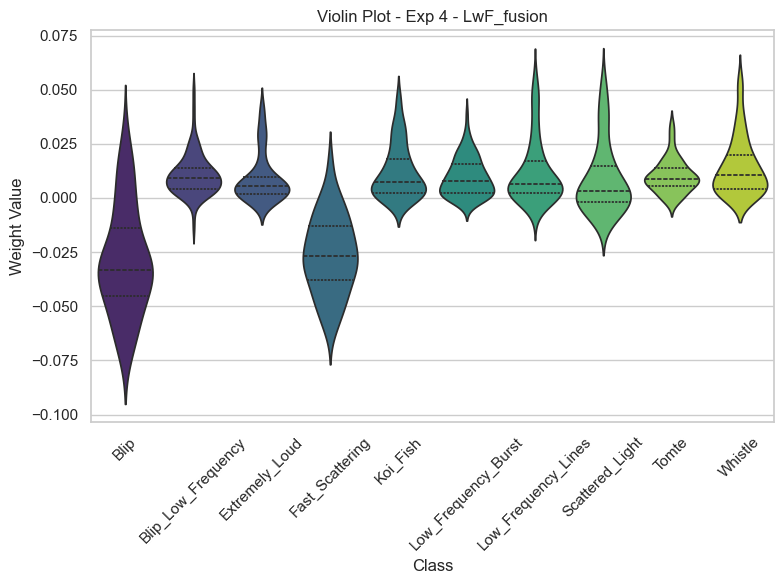

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Loss_Epoch/train_phase/train_stream/Task000']
cl_simple_train_loop: 992625.8411407471 ms


In [36]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'LwF_fusion')

In [37]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_MultiView_LwF_CL.pth')

Saved Pytorch model state to  Models/thesis_MultiView_LwF_CL.pth


In [38]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 42986.81974411011 ms


In [39]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

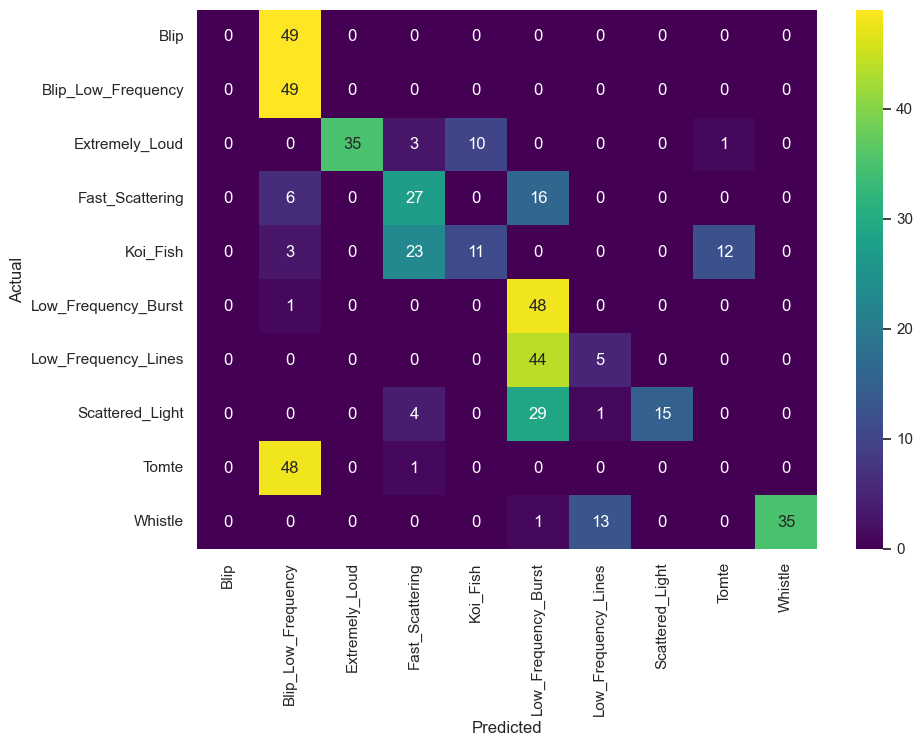

In [40]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_LwF_MultiView.png')

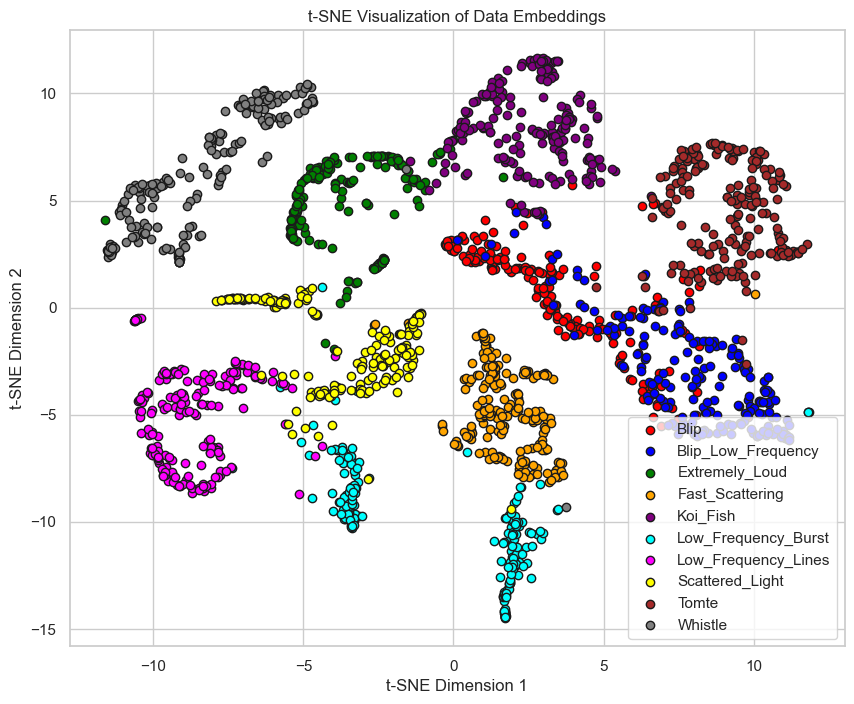

plot_tSNE_data_embedding: 69629.5702457428 ms


In [41]:
# PLOT t-SNE
my_utils.plot_tSNE_data_embedding(model, train_loader_av, classes, 'Results/tSNE_LwF_MultiView.png')

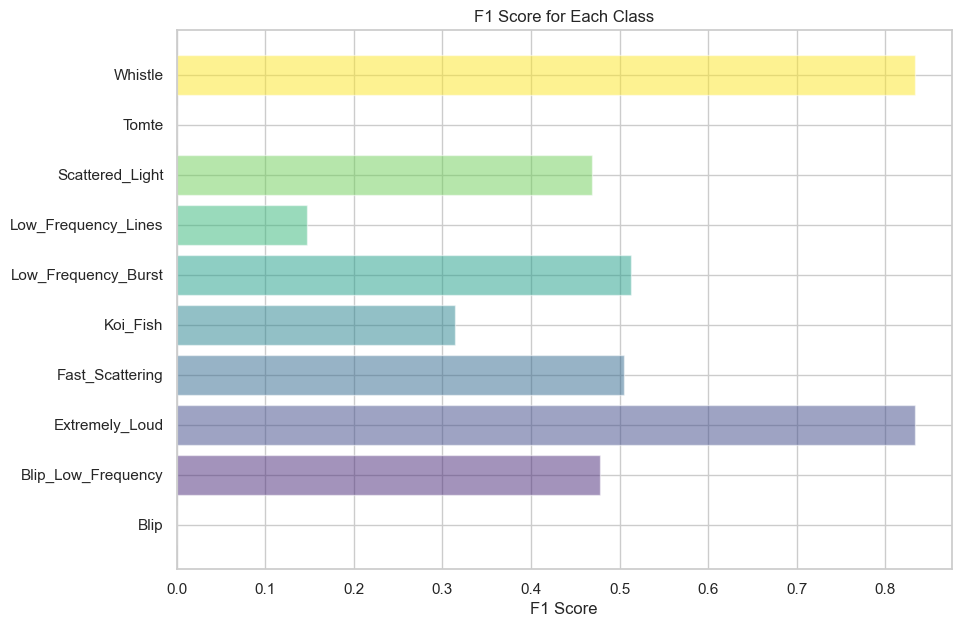

In [42]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_LwF_MultiView.png')

# TASK INCREMENTAL - Instance based

## Naive

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
model.to(device)
# log to text file
text_logger = TextLogger(open("multiview_fusion_TaskBased_log.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

In [45]:
bm = ni_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=5,
    shuffle=True,
    seed=1234,
    task_labels=False,
)

In [46]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=False, stream=True),
    ram_usage_metrics(experience=True, stream=True, epoch=False),
    bwt_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

In [47]:
# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss(label_smoothing=0.2)

In [48]:
# NAIVE STRATEGY
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=50, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), EarlyStoppingPlugin(patience=2, val_stream_name='valid')]
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.Naive object at 0x0000022C5BB91090>
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:21<00:00,  1.67s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.8723
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4925
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:21<00:00,  1.62s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3682
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8100
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:21<00:00,  1.63s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1650
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8925
100%|█████████████████████████

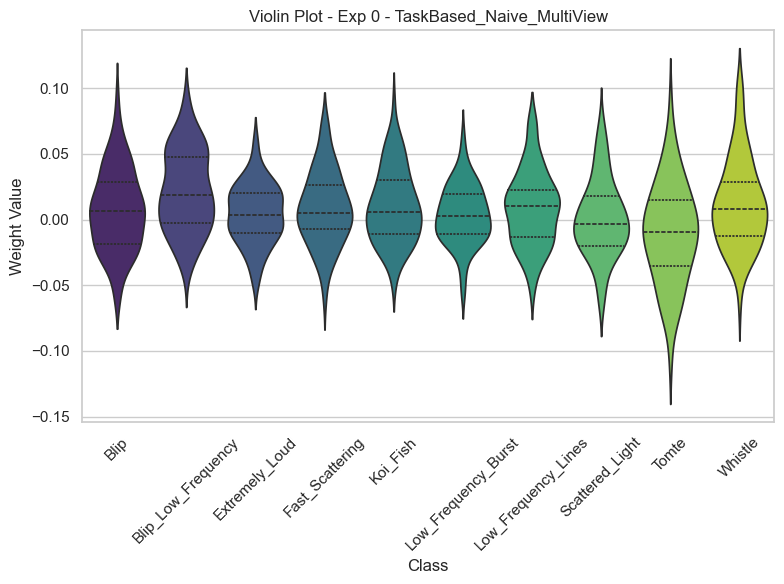

Start of experience:  1
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.20s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0001
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9487
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.20s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9708
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9637
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.20s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9439
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9825
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.21s/it]
Epoch 3 ended.
	Loss_Epoch/tra

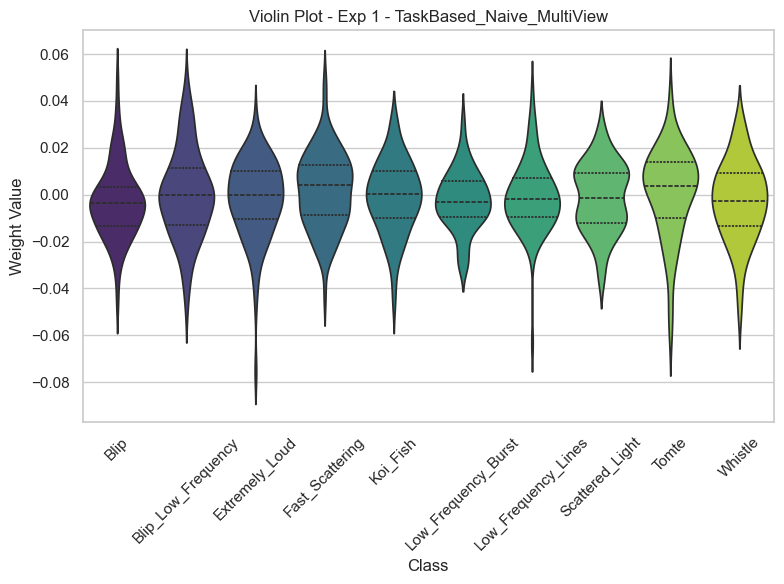

Start of experience:  2
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:51<00:00,  3.98s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9644
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9669
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.27s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9606
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9681
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.25s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9413
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9828
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.23s/it]
Epoch 3 ended.
	Loss_Epoch/tra

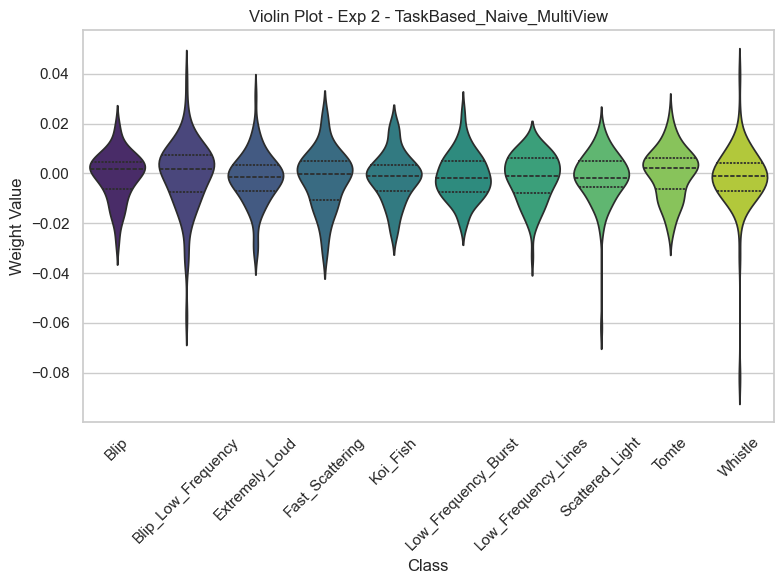

Start of experience:  3
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:52<00:00,  4.02s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9820
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9583
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.26s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9734
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9608
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.26s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9339
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9828
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.30s/it]
Epoch 3 ended.
	Loss_Epoch/tra

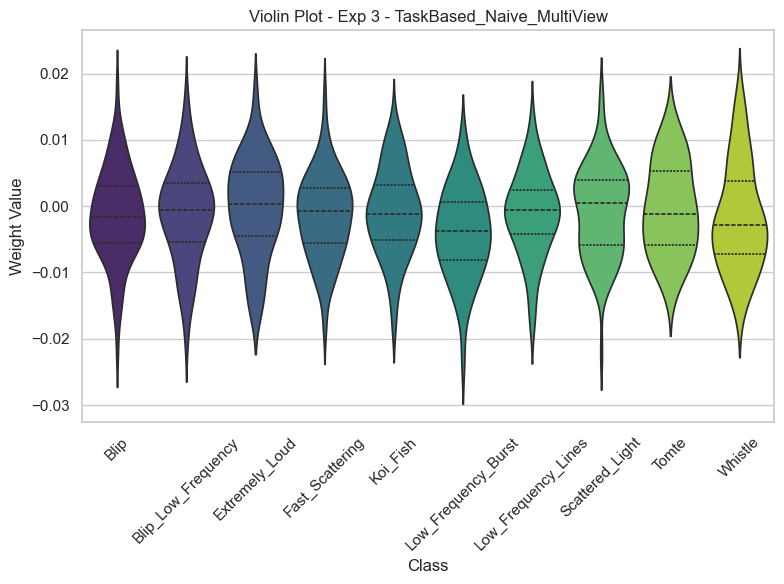

Start of experience:  4
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:51<00:00,  3.96s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9546
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9681
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.26s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9573
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9730
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.24s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9398
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9841
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.25s/it]
Epoch 3 ended.
	Loss_Epoch/tra

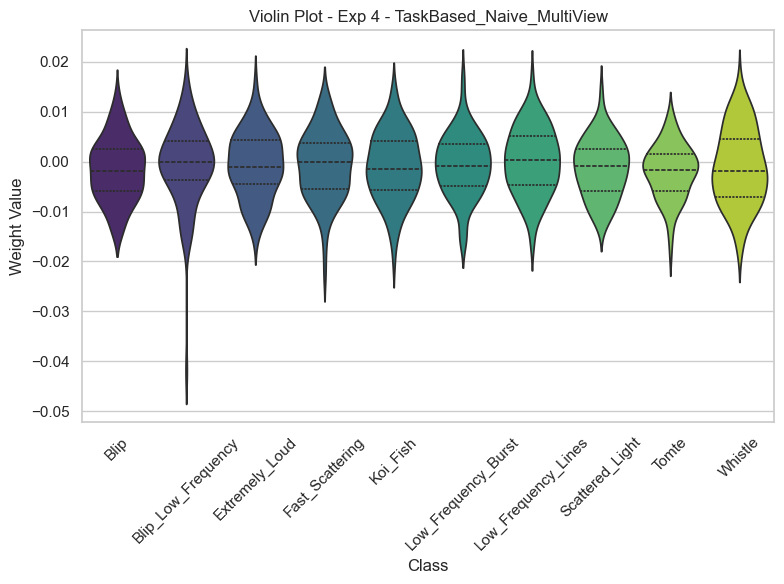

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Loss_Epoch/train_phase/train_stream/Task000']
cl_simple_train_loop: 9528788.024187088 ms


In [49]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'TaskBased_Naive_MultiView', scr=False)

In [50]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_TaskBased_Naive_MultiView.pth')

Saved Pytorch model state to  Models/thesis_TaskBased_Naive_MultiView.pth


In [51]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 63132.7965259552 ms


In [52]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

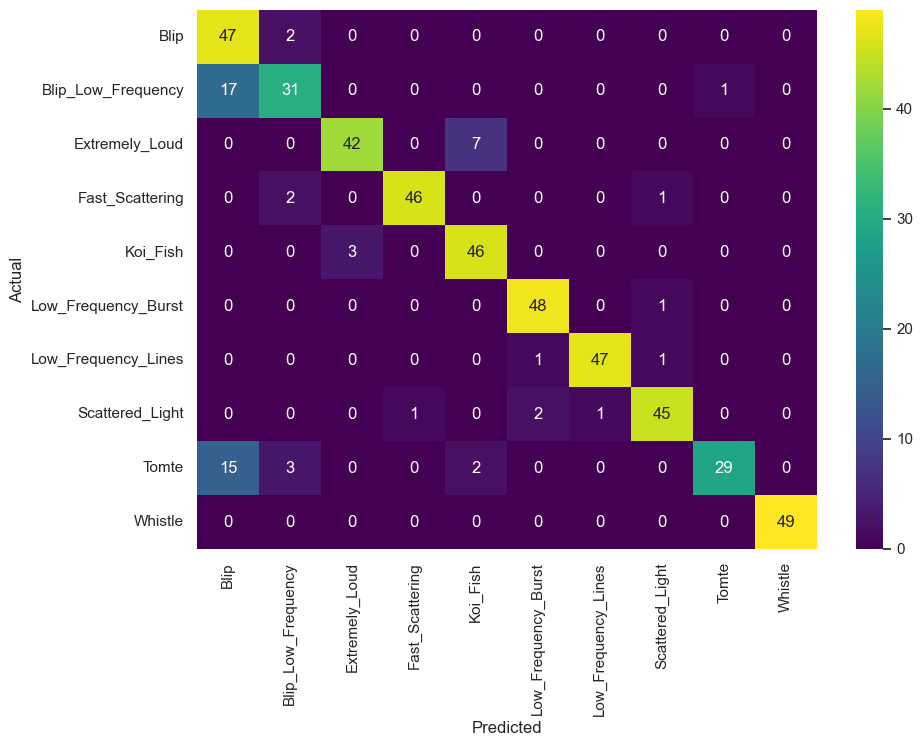

In [53]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_TaskBased_Naive_MultiView.png')

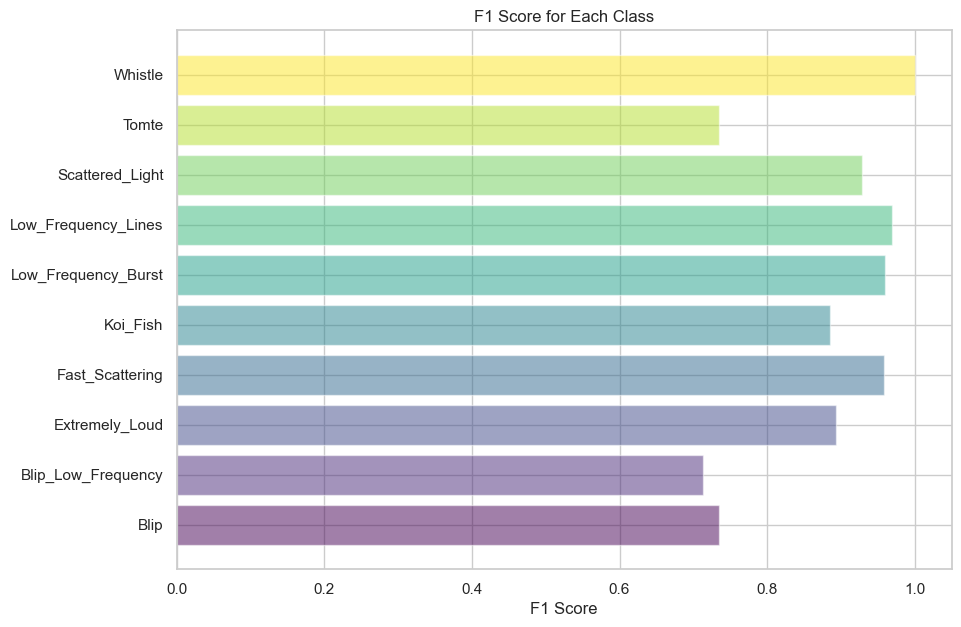

In [55]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_TaskBased_Naive_MultiView.png')

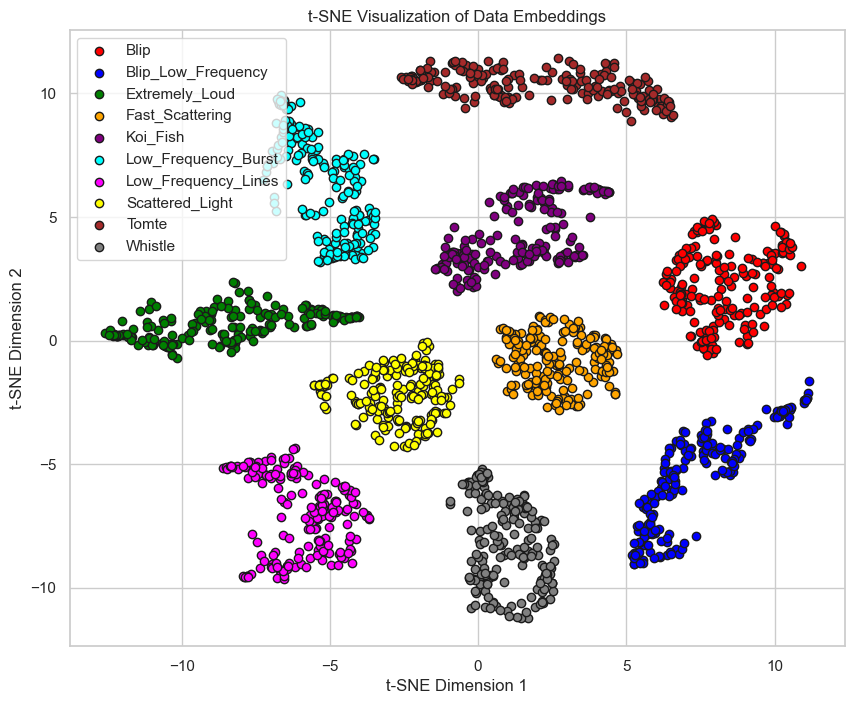

plot_tSNE_data_embedding: 69158.41436386108 ms


In [56]:
# PLOT t-SNE
my_utils.plot_tSNE_data_embedding(model, train_loader_av, classes, 'Results/tSNE_taskBased__Naive_MultiView.png')

SCR

In [57]:
from avalanche.training import SCR, SCRLoss
from avalanche.models import SCRModel
resnet18 = my_architectures.MultiViewColorNet_resnet18(num_classes=10)
resnet18.to(device)
projection_network = nn.Linear(10, 512)  # Adjust the output size as needed
projection_network.to(device)
scr_model = SCRModel(feature_extractor=resnet18, projection=projection_network)
optimizer = SGD(model.parameters(), lr=0.001, weight_decay=1e-5) #although in the paper lr = 0.1 initially
criterion = CrossEntropyLoss(label_smoothing=0.2)
scr_model.to(device)

SCRModel(
  (ncm): NCMClassifier()
  (feature_extractor): MultiViewColorNet_resnet18(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

In [58]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=False, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=False, experience=True, stream=True),
    #forgetting_metrics(experience=False, stream=True),
    #bwt_metrics(experience=True, stream=True),
    #forward_transfer_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()],
    strict_checks=False,
)

In [59]:
# SCR STRATEGY
cl_strategy = SCR(
    model=scr_model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=50, 
    eval_mb_size=16, mem_size=1000, temperature=0.1, device=device, evaluator=eval_plugin
)

Starting experiment with strategy: <avalanche.training.supervised.supervised_contrastive_replay.SCR object at 0x0000022FB2137D90>
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:22<00:00,  1.70s/it]
Epoch 0 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:21<00:00,  1.66s/it]
Epoch 1 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:22<00:00,  1.70s/it]
Epoch 2 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:21<00:00,  1.65s/it]
Epoch 3 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:22<00:00,  1.70s/it]
Epoch 4 ended.
100%|█████████████████████████████████████████████████████████████████████████████████

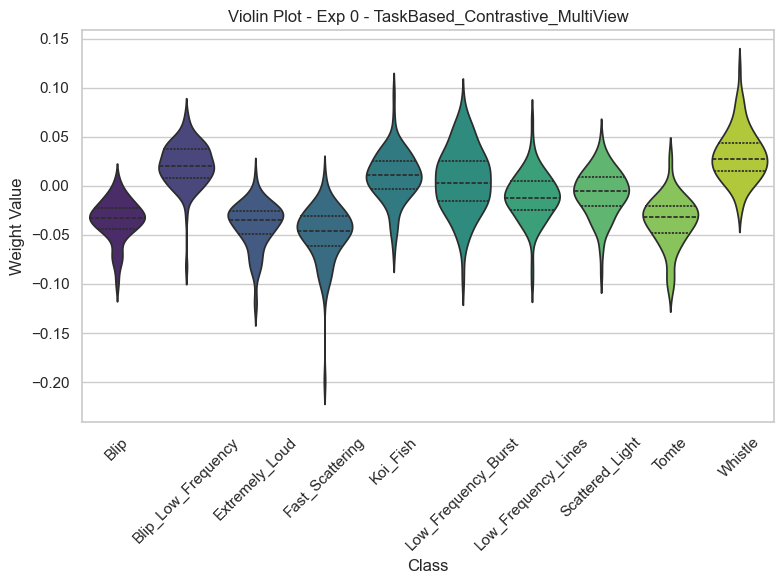

Start of experience:  1
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [04:02<00:00, 18.67s/it]
Epoch 0 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:59<00:00, 13.82s/it]
Epoch 1 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:00<00:00, 13.86s/it]
Epoch 2 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:59<00:00, 13.82s/it]
Epoch 3 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:00<00:00, 13.87s/it]
Epoch 4 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:03<00:00, 14.12s/it]
Epoch 5 ended.
100%|████████████████████████████████████████████████████████████████████████████

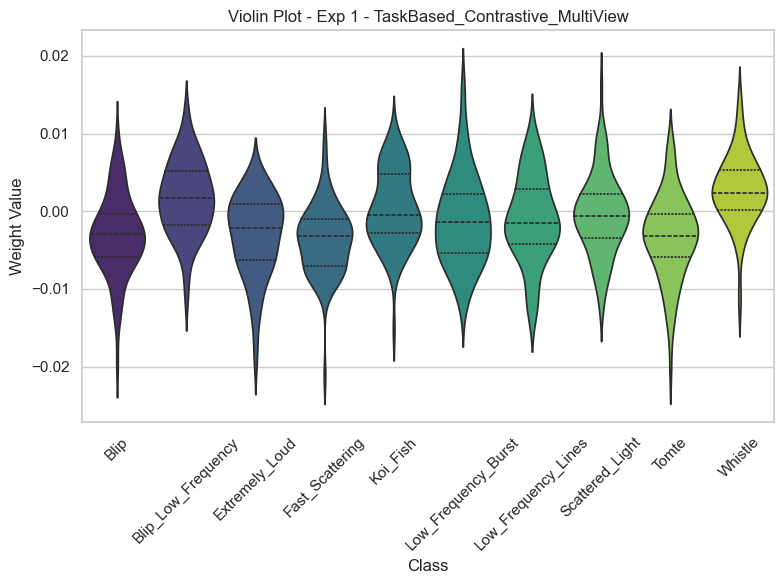

Start of experience:  2
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:09<00:00, 14.55s/it]
Epoch 0 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:11<00:00, 14.74s/it]
Epoch 1 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:11<00:00, 14.73s/it]
Epoch 2 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:11<00:00, 14.75s/it]
Epoch 3 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:11<00:00, 14.71s/it]
Epoch 4 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:12<00:00, 14.83s/it]
Epoch 5 ended.
100%|████████████████████████████████████████████████████████████████████████████

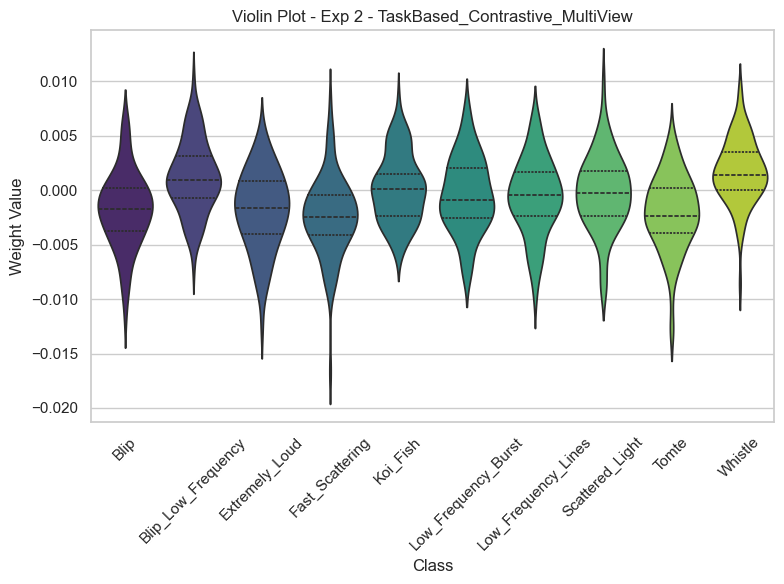

Start of experience:  3
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:17<00:00, 15.17s/it]
Epoch 0 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:11<00:00, 14.71s/it]
Epoch 1 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:10<00:00, 14.62s/it]
Epoch 2 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:10<00:00, 14.64s/it]
Epoch 3 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:09<00:00, 14.60s/it]
Epoch 4 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:10<00:00, 14.62s/it]
Epoch 5 ended.
100%|████████████████████████████████████████████████████████████████████████████

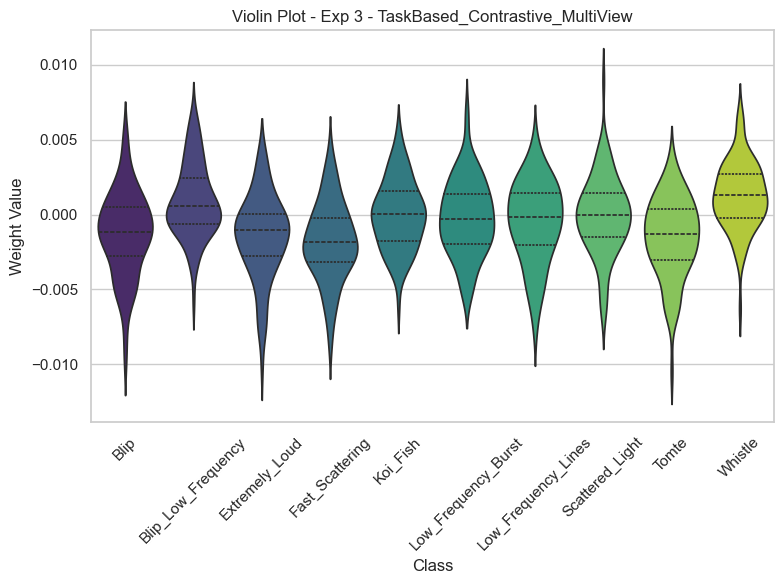

Start of experience:  4
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:18<00:00, 15.30s/it]
Epoch 0 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:15<00:00, 15.05s/it]
Epoch 1 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:12<00:00, 14.78s/it]
Epoch 2 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:11<00:00, 14.75s/it]
Epoch 3 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:11<00:00, 14.74s/it]
Epoch 4 ended.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:11<00:00, 14.71s/it]
Epoch 5 ended.
100%|████████████████████████████████████████████████████████████████████████████

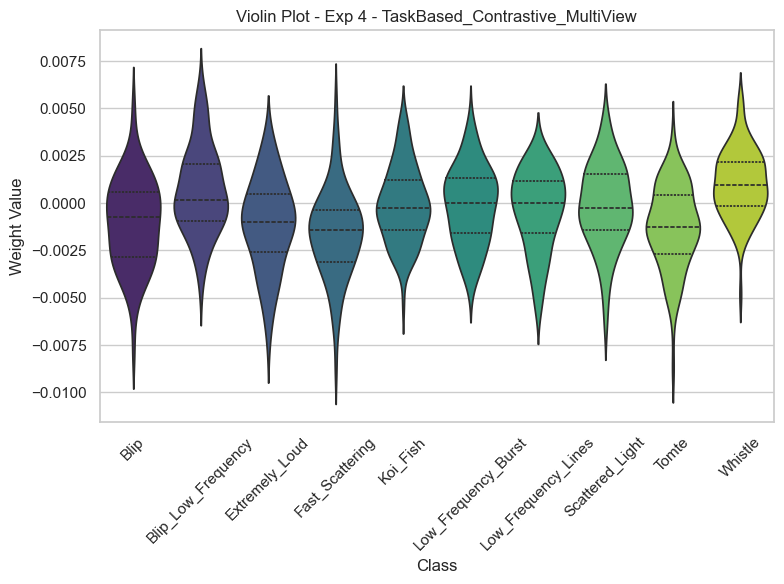

Stored metrics: []
cl_simple_train_loop: 39200442.23213196 ms


In [60]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, scr_model, optimizer, number_of_workers, classes, 'TaskBased_Contrastive_MultiView', scr=True)

In [61]:
# SAVE MODEL
my_utils.checkpoint(scr_model, 'Models/thesis_TaskBased_Contrastive_MultiView.pth')

Saved Pytorch model state to  Models/thesis_TaskBased_Contrastive_MultiView.pth


In [62]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(scr_model, test_loader_av)

get_predictions: 64084.52224731445 ms


In [63]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

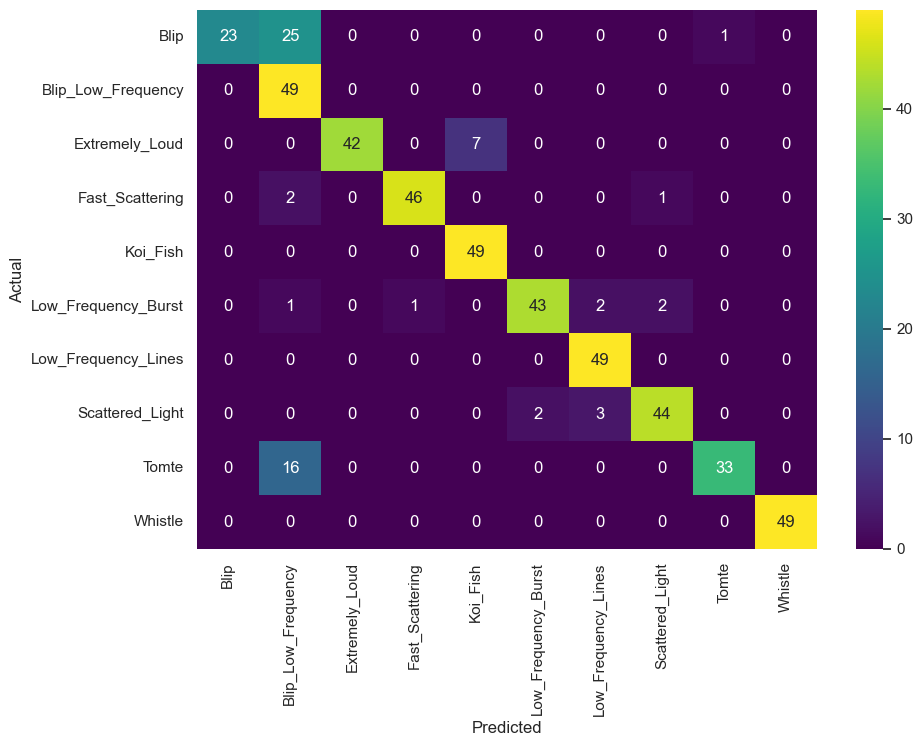

In [64]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_TaskBased_Contrastive_MultiView.png')

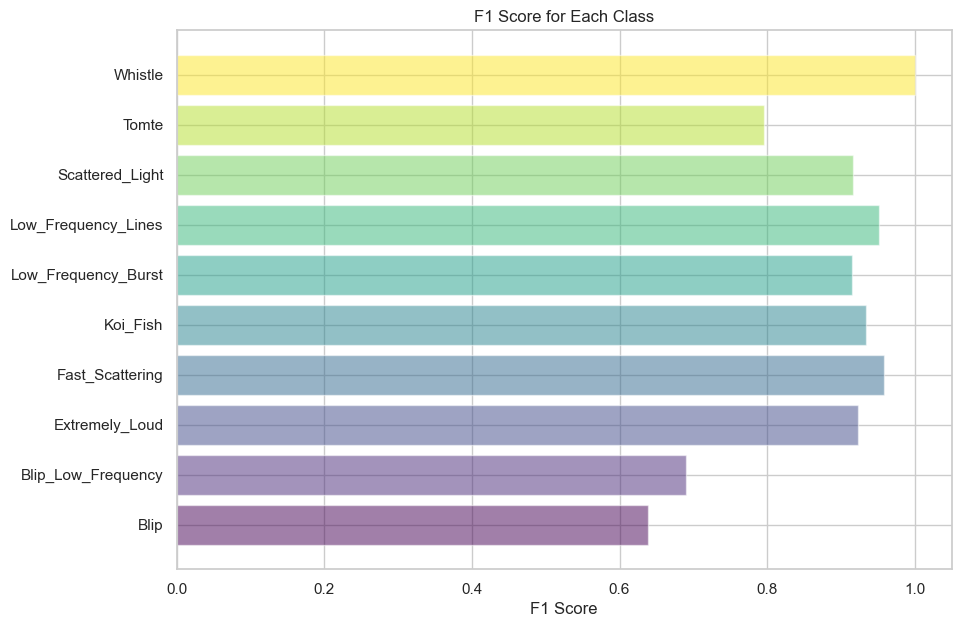

In [65]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_TaskBased_Contrastive_MultiView.png')

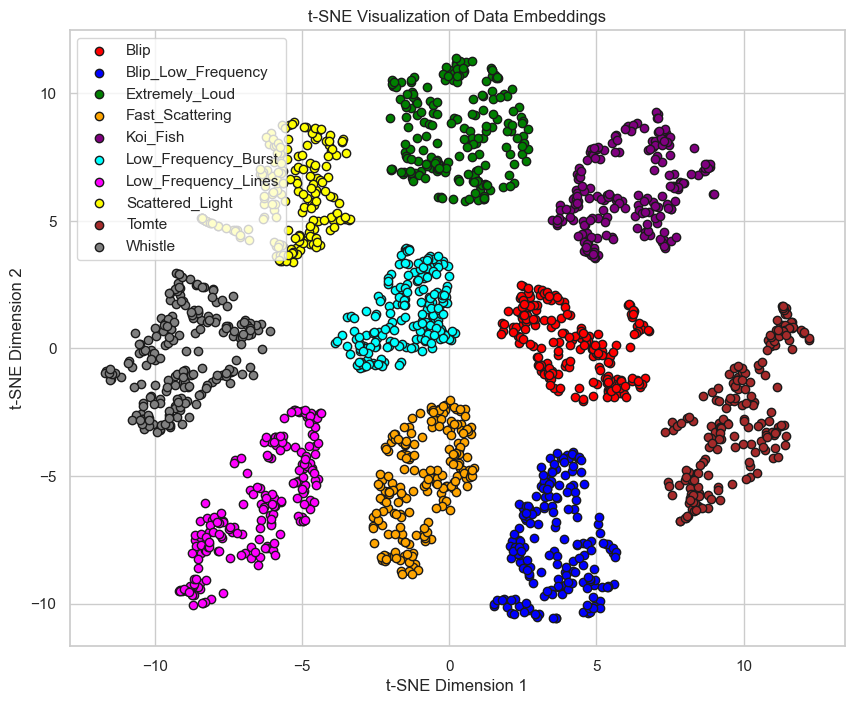

plot_tSNE_data_embedding: 168770.49612998962 ms


In [67]:
# PLOT t-SNE
my_utils.plot_tSNE_data_embedding(scr_model, train_loader_av, classes, 'Results/tSNE_Contrastive_MultiView.png')